In [4]:
import tensorflow as tf
import pathlib

def _example_to_tensors(example, input_shape):
    """
    @brief: Read a serialized tf.train.Example and convert it to a (image, label) pair of tensors.
            TFRecords are created using src/create_coco_vww_tf_record.py 
    @author: Daniel Tan
    """
    example = tf.io.parse_example(
        example[tf.newaxis], {
            'image/encoded': tf.io.FixedLenFeature(shape = (), dtype=tf.string),
            'image/class': tf.io.FixedLenFeature(shape = (), dtype=tf.int64)
        })
    img_tensor =  tf.io.decode_jpeg(example['image/encoded'][0])
    img_tensor = tf.image.resize(img_tensor, size=(input_shape.height, input_shape.width))
    label = example['image/class']
    return img_tensor, label

def load_dataset(dataset_name, input_shape, split="train"):
    """
    Parameters: 
        split: 'train' or 'val'
        dataset_name: A subdirector of data/vww_tfrecord
        input_shape: An ImageShape instance
        
    Return: 
        A dataset where each entry is a (image, label) tuple
    """
    datadir = pathlib.Path('data/vww_tfrecord') / dataset_name
    filenames = [str(p) for p in datadir.glob(f"coco_{split}.record*")]
    tfrecords = tf.data.TFRecordDataset(filenames)
    def _map_fn(example):
        return _example_to_tensors(example, input_shape)
    dataset = tfrecords.map(_map_fn)
    return dataset.filter(lambda x, y: tf.shape(x)[2] == 3)
    
def build_model(input_shape, alpha):
    """
    Build a MobilenetV1 architecture with given input shape and alpha. 
    
    Parameters:
        input_shape: An ImageShape instance
        alpha: A float between 0 and 1. Model size scales with (alpha^2).
     
    Returns:
        A newly initialized model with the given architecture. 
    """
    input_shape = (input_shape.height, input_shape.width, input_shape.channels)
    backbone = tf.keras.applications.MobileNet(
        input_shape = input_shape, alpha=alpha, include_top=False, weights='imagenet'
    )
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    regressor = tf.keras.Sequential(
        [tf.keras.layers.GlobalAveragePooling2D(),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(1, activation=None)]
    )

    inputs = tf.keras.Input(input_shape)
    x = inputs
    x = preprocess_input(x)
    x = backbone(x)
    outputs = regressor(x)
    model = tf.keras.Model(inputs, outputs)
    return model
    


/opt/conda/envs/tf-detect/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


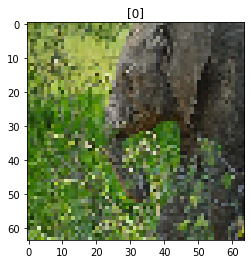

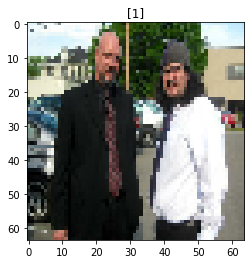

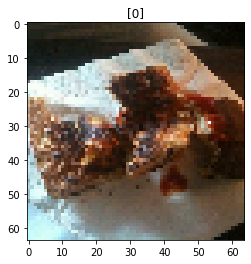

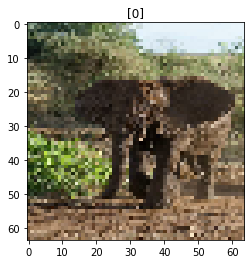

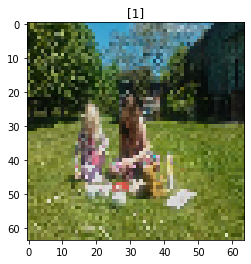

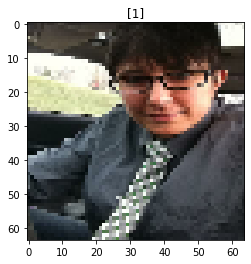

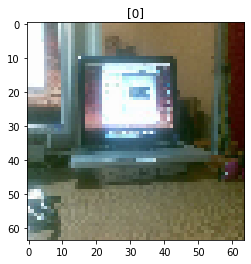

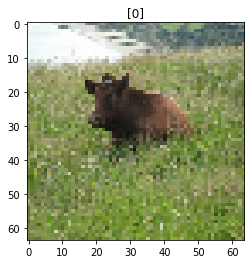

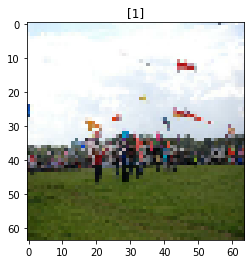

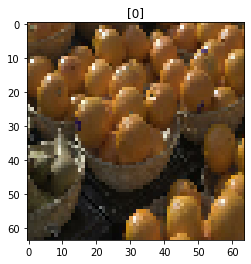

In [5]:
import matplotlib.pyplot as plt
from collections import namedtuple

ImgShape = namedtuple('ImageShape', 'height width channels')
INPUT_SHAPE = ImgShape(height=64, width=64, channels=3)
    
train_dataset = load_dataset('coco2014', INPUT_SHAPE, split="train")
val_dataset = load_dataset('coco2014', INPUT_SHAPE, split="val")

for img, label in train_dataset.shuffle(128).take(5):
    plt.figure()
    plt.imshow(img.numpy() / 255)
    plt.title(label.numpy())
    
for img, label in val_dataset.shuffle(128).take(5):
    plt.figure()
    plt.imshow(img.numpy() / 255)
    plt.title(label.numpy())

Overfit experiment. 

If our dataset is well-formed, a relatively powerful model should be able to achieve good results. 

In [ ]:
! python -m pip install tf

In [ ]:
! python src/train_vww_model.py --dataset coco2014 --verbose 1 --alpha 1.0 --input-height=256 --input-width=256 --batch-size 64

2020-09-04 07:26:39.435531: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-04 07:26:40.885391: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-04 07:26:40.889696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-04 07:26:40.890506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-09-04 07:26:40.890562: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-04 07:26:40.892600: I tensorflow/stream_executor/platform/defa

1291/1291 [==============================] - 1430s 1s/step - loss: 0.6584 - accuracy: 0.5659 - val_loss: 0.6511 - val_accuracy: 0.5927
Epoch 5/20
1291/1291 [==============================] - 1432s 1s/step - loss: 0.6374 - accuracy: 0.5995 - val_loss: 0.6354 - val_accuracy: 0.6026
Epoch 6/20
 171/1291 [==>...........................] - ETA: 17:48 - loss: 0.6271 - accuracy: 0.6152